In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import pathlib

import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

In [2]:
DEFAULT_FIGSIZE = (9, 6)

def show_tiff(filename:str, figsize=DEFAULT_FIGSIZE, vmin=None, vmax=None, rescale_percentile=97, add_colorbar=False):
    """Small helper to load a geotiff and visualize it"""
    with rasterio.open(filename) as ds:
        data = ds.read()

    fig, ax = plt.subplots(figsize=figsize)

    if len(data.shape) == 3:
        if data.max() > 500:
            p = np.percentile(data, rescale_percentile, axis=[1,2])
            data = data / p[:, None, None]
            data = np.clip(data, 0, 1)        
        data = np.moveaxis(data, 0, 2)
        if data.shape[2]<3:
            data = data[:,:,0]
        
    im = ax.imshow(data, vmin=vmin, vmax=vmax,cmap="RdYlGn")
    if add_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.05)

out_dir = pathlib.Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

In [3]:
openeo.client_version()

'0.7.1a1'

# Create a connection

It all starts with creating a connection to the desired openEO backend as follows:


In [4]:
con = openeo.connect("https://earthengine.openeo.org")
con

<Connection to 'https://earthengine.openeo.org/v1.0' with NullAuth>

In [5]:
con.list_collections()

[{'stac_version': '1.0.0-beta.2',
  'stac_extensions': [],
  'id': 'AAFC/ACI',
  'title': 'Canada AAFC Annual Crop Inventory',
  'description': 'Starting in 2009, the Earth Observation Team of the Science and Technology\nBranch (STB) at Agriculture and Agri-Food Canada (AAFC) began the process\nof generating annual crop type digital maps. Focusing on the Prairie\nProvinces in 2009 and 2010, a Decision Tree (DT) based methodology was\napplied using optical (Landsat-5, AWiFS, DMC) and radar (Radarsat-2) based\nsatellite images. Beginning with the 2011 growing season, this activity has\nbeen extended to other provinces in support of a national crop inventory.\nTo date this approach can consistently deliver a crop inventory that meets\nthe overall target accuracy of at least 85% at a final spatial resolution of\n30m (56m in 2009 and 2010).\n',
  'license': 'proprietary',
  'providers': [{'name': 'Agriculture and Agri-Food Canada',
    'roles': ['producer', 'licensor'],
    'url': 'https://open.canada.ca/data/en/dataset/ba2645d5-4458-414d-b196-6303ac06c1c9'},
   {'name': 'Google Earth Engine',
    'roles': ['host'],
    'url': 'https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI'}],
  'extent': {'spatial': {'bbox': [[-135.17, 36.83, -51.24, 62.25]]},
   'temporal': {'interval': [['2009-01-01T00:00:00Z', None]]}},
  'links': [{'rel': 'self',
    'href': 'https://earthengine.openeo.org/v1.0/collections/AAFC/ACI'},
   {'rel': 'parent',
    'href': 'https://earthengine.openeo.org/v1.0/collections'},
   {'rel': 'root', 'href': 'https://earthengine.openeo.org/v1.0/'},
   {'rel': 'preview',
    'href': 'https://mw1.google.com/ges/dd/images/AAFC_ACI_sample.png'},
   {'rel': 'license',
    'href': 'https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI#terms-of-use'},
   {'rel': 'source',
    'href': 'http://www.agr.gc.ca/atlas/data_donnees/agr/annualCropInventory/tif/'}]},
 {'stac_version': '1.0.0-beta.2',
  'stac_extensions': [],
  'id': 'AHN/AHN2_05M_INT',
  'title': 'AHN Netherlands 0.5m DEM, Interpolated',
  'description': 'The AHN DEM is a 0.5m DEM covering the Netherlands. It was generated from LIDAR data taken in the spring between 2007 and 2012.\n\nIt contains ground level samples with all other items above ground (such as buildings, bridges, trees etc.) removed. This version is interpolated; the areas where objects have been removed are filled with interpolated values. The point cloud was converted to a 0.5m grid using a squared inverse distance weighting method.\nNote: This dataset does not include a small number of tiles listed in the manifest that are only available at a lower resolution.',
  'license': 'proprietary',
  'providers': [{'name': 'AHN',
    'roles': ['producer', 'licensor'],
    'url': 'http://www.ahn.nl/index.html'},
   {'name': 'Google Earth Engine',
    'roles': ['host'],
    'url': 'https://developers.google.com/earth-engine/datasets/catalog/AHN_AHN2_05M_INT'}],
  'extent': {'spatial': {'bbox': [[3.35, 50.74, 7.24, 53.55]]},
   'temporal': {'interval': [['2012-01-01T00:00:00Z',
      '2012-01-01T00:00:00Z']]}},
  'links': [{'rel': 'self',
    'href': 'https://earthengine.openeo.org/v1.0/collections/AHN/AHN2_05M_INT'},
   {'rel': 'parent',
    'href': 'https://earthengine.openeo.org/v1.0/collections'},
   {'rel': 'root', 'href': 'https://earthengine.openeo.org/v1.0/'},
   {'rel': 'preview',
    'href': 'https://mw1.google.com/ges/dd/images/AHN_AHN2_05M_INT_sample.png'},
   {'rel': 'license',
    'href': 'https://developers.google.com/earth-engine/datasets/catalog/AHN_AHN2_05M_INT#terms-of-use'}]},
 {'stac_version': '1.0.0-beta.2',
  'stac_extensions': [],
  'id': 'AHN/AHN2_05M_NON',
  'title': 'AHN Netherlands 0.5m DEM, Non-Interpolated',
  'description': 'The AHN DEM is a 0.5m DEM covering the Netherlands. It was generated from LIDAR data taken in the spring between 2007 and 2012.\n\nIt contains ground level samples with all other items above ground (such as buildings, bridges, tr

In [6]:
con.describe_collection("LANDSAT/LC08/C01/T1_TOA")

{'stac_version': '1.0.0-beta.2',
 'id': 'LANDSAT/LC08/C01/T1_TOA',
 'title': 'USGS Landsat 8 Collection 1 Tier 1 TOA Reflectance',
 'gee:type': 'image_collection',
 'description': 'Landsat 8 Collection 1 Tier 1\n  calibrated top-of-atmosphere (TOA) reflectance.\n  Calibration coefficients are extracted from the image metadata.  See\n  <a href="http://www.sciencedirect.com/science/article/pii/S0034425709000169">\n  Chander et al. (2009)</a> for details on the TOA computation.</p>',
 'license': 'proprietary',
 'links': [{'rel': 'self',
   'href': 'https://earthengine.openeo.org/v1.0/collections/LANDSAT/LC08/C01/T1_TOA'},
  {'rel': 'parent', 'href': 'https://earthengine.openeo.org/v1.0/collections'},
  {'rel': 'root', 'href': 'https://earthengine.openeo.org/v1.0/'},
  {'rel': 'preview',
   'href': 'https://mw1.google.com/ges/dd/images/LANDSAT_TOA_sample.png'},
  {'rel': 'license',
   'href': 'https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_TOA#terms-of-use'}],
 'keywords': ['global', 'landsat', 'toa', 'usgs'],
 'providers': [{'name': 'USGS/Google',
   'roles': ['producer', 'licensor'],
   'url': ''},
  {'name': 'Google Earth Engine',
   'roles': ['host'],
   'url': 'https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_TOA'}],
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2013-04-11T00:00:00Z', None]]}},
 'summaries': {'gee:schema': [{'BPF_NAME_OLI': {'description': 'The file name for the Bias Parameter File (BPF) used to generate the product, if applicable. This only applies to products that contain OLI bands.',
     'type': 'STRING'},
    'BPF_NAME_TIRS': {'description': 'The file name for the Bias Parameter File (BPF) used to generate the product, if applicable. This only applies to products that contain TIRS bands.',
     'type': 'STRING'},
    'CLOUD_COVER': {'description': 'Percentage cloud cover, -1 = not calculated.',
     'type': 'DOUBLE'},
    'CLOUD_COVER_LAND': {'description': 'Percentage cloud cover over land, -1 = not calculated.',
     'type': 'DOUBLE'},
    'COLLECTION_CATEGORY': {'description': 'Tier of scene. (T1 or T2)',
     'type': 'STRING'},
    'COLLECTION_NUMBER': {'description': 'Number of collection.',
     'type': 'DOUBLE'},
    'CPF_NAME': {'description': 'Calibration parameter file name.',
     'type': 'STRING'},
    'DATA_TYPE': {'description': 'Data type identifier. (L1T or L1G)',
     'type': 'STRING'},
    'DATE_ACQUIRED': {'description': 'Image acquisition date. "YYYY-MM-DD"',
     'type': 'STRING'},
    'DATUM': {'description': 'Datum used in image creation.',
     'type': 'STRING'},
    'EARTH_SUN_DISTANCE': {'description': 'Earth sun distance in astronomical units (AU).',
     'type': 'DOUBLE'},
    'ELEVATION_SOURCE': {'description': 'Elevation model source used for standard terrain corrected (L1T) products.',
     'type': 'STRING'},
    'ELLIPSOID': {'description': 'Ellipsoid used in image creation.',
     'type': 'STRING'},
    'EPHEMERIS_TYPE': {'description': 'Ephemeris data type used to perform geometric correction. (Definitive or Predictive)',
     'type': 'STRING'},
    'FILE_DATE': {'description': 'File date in milliseconds since epoch.',
     'type': 'DOUBLE'},
    'GEOMETRIC_RMSE_MODEL': {'description': 'Combined Root Mean Square Error (RMSE) of the geometric residuals\n(metres) in both across-track and along-track directions\nmeasured on the GCPs used in geometric precision correction.\nNot present in L1G products.\n',
     'type': 'DOUBLE'},
    'GEOMETRIC_RMSE_MODEL_X': {'description': 'RMSE of the X direction geometric residuals (in metres) measured\non the GCPs used in geometric precision correction. Not present in\nL1G products.\n',
     'type': 'DOUBLE'},
    'GEOMETRIC_RMSE_MODEL_Y': {'description': 'RMSE of the Y direction geometric residuals (in metres) measured\non the GCPs used in geometric precision correction. Not present in\nL1G products.\n',
     'type': 'DOUBLE'},
    

In [7]:
con.list_processes()

[{'id': 'absolute',
  'summary': 'Absolute value',
  'description': 'Computes the absolute value of a real number `x`, which is the "unsigned" portion of x and often denoted as *|x|*.\n\nThe no-data value `null` is passed through and therefore gets propagated.',
  'categories': ['math'],
  'parameters': [{'name': 'x',
    'description': 'A number.',
    'schema': {'type': ['number', 'null']}}],
  'returns': {'description': 'The computed absolute value.',
   'schema': {'type': ['number', 'null'], 'minimum': 0}},
  'examples': [{'arguments': {'x': 0}, 'returns': 0},
   {'arguments': {'x': 3.5}, 'returns': 3.5},
   {'arguments': {'x': -0.4}, 'returns': 0.4},
   {'arguments': {'x': -3.5}, 'returns': 3.5}],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/AbsoluteValue.html',
    'title': 'Absolute value explained by Wolfram MathWorld'}]},
 {'id': 'add',
  'summary': 'Addition of two numbers',
  'description': 'Sums up the two numbers `x` and `y` (*x + y*) and returns the computed sum.\n\nNo-data values are taken into account so that `null` is returned if any element is such a value.\n\nThe computations follow [IEEE Standard 754](https://ieeexplore.ieee.org/document/8766229) whenever the processing environment supports it.',
  'categories': ['math'],
  'parameters': [{'name': 'x',
    'description': 'The first summand.',
    'schema': {'type': ['number', 'null']}},
   {'name': 'y',
    'description': 'The second summand.',
    'schema': {'type': ['number', 'null']}}],
  'returns': {'description': 'The computed sum of the two numbers.',
   'schema': {'type': ['number', 'null']}},
  'examples': [{'arguments': {'x': 5, 'y': 2.5}, 'returns': 7.5},
   {'arguments': {'x': -2, 'y': -4}, 'returns': -6},
   {'arguments': {'x': 1, 'y': None}, 'returns': None}],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/Sum.html',
    'title': 'Sum explained by Wolfram MathWorld'},
   {'rel': 'about',
    'href': 'https://ieeexplore.ieee.org/document/8766229',
    'title': 'IEEE Standard 754-2019 for Floating-Point Arithmetic'}]},
 {'id': 'add_dimension',
  'summary': 'Add a new dimension',
  'description': 'Adds a new named dimension to the data cube.\n\nAfterwards, the dimension can be referenced with the specified `name`. If a dimension with the specified name exists, the process fails with a `DimensionExists` error. The dimension label of the dimension is set to the specified `label`.',
  'categories': ['cubes'],
  'parameters': [{'name': 'data',
    'description': 'A data cube to add the dimension to.',
    'schema': {'type': 'object', 'subtype': 'raster-cube'}},
   {'name': 'name',
    'description': 'Name for the dimension.',
    'schema': {'type': 'string'}},
   {'name': 'label',
    'description': 'A dimension label.',
    'schema': [{'type': 'number'}, {'type': 'string'}]},
   {'name': 'type',
    'description': 'The type of dimension, defaults to `other`.',
    'schema': {'type': 'string',
     'enum': ['spatial', 'temporal', 'bands', 'other']},
    'default': 'other',
    'optional': True}],
  'returns': {'description': 'The data cube with a newly added dimension. The new dimension has exactly one dimension label. All other dimensions remain unchanged.',
   'schema': {'type': 'object', 'subtype': 'raster-cube'}},
  'exceptions': {'DimensionExists': {'message': 'A dimension with the specified name already exists.'}}},
 {'id': 'aggregate_temporal_frequency',
  'summary': 'Temporal aggregations based on frequencies',
  'description': 'Computes a temporal aggregation based on calendar hierarchies such as year, month, week or seasons. For other calendar hierarchies ``aggregate_temporal()`` can be used.\n\nFor each interval, all data along the dimension will be passed through the reducer.\n\nIf the dimension is not set or is set to `null`, the data cube is expected to only have one temporal dimension.',
  'categories': ['aggregate & resample', 'climatology', 'cubes'],
  'parameters': [{'name': 'data',
 

In [8]:
con.authenticate_basic("group1", "test123")

<Connection to 'https://earthengine.openeo.org/v1.0' with BearerAuth>

In [9]:
bands = ["B6", "B5", "B3"]
dates = ("2021-03-06")

In [10]:
cube = con.load_collection("LANDSAT/LC08/C01/T1", bands=bands)
cube = cube.filter_bbox(west=110.83, south=-8.01, east=110.99, north=-7.83)
cube = cube.filter_temporal(dates)

In [11]:
%%time
cube.download(out_dir / "basic.tiff", format="GTIFF-THUMB")

CPU times: user 99.3 ms, sys: 130 ms, total: 230 ms
Wall time: 4.49 s


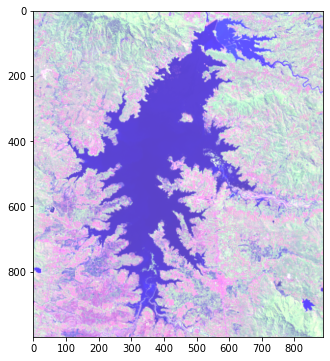

In [12]:
show_tiff(out_dir / "basic.tiff")

In [13]:
# ndwi = cube.normalized_difference(cube.band("B3"), cube.band("B6")

green = cube.band("B3")
nir = cube.band("B6")

ndwi = (green - nir)/(green + nir)

In [14]:
%time ndwi.download(out_dir / "ndwi.tiff", format="GTIFF-THUMB")

CPU times: user 59.8 ms, sys: 85.8 ms, total: 146 ms
Wall time: 6.65 s


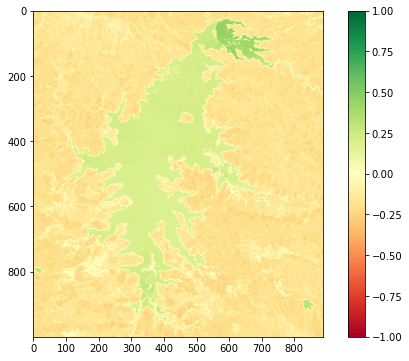

In [15]:
show_tiff(out_dir / "ndwi.tiff", vmin=-1, vmax=1, add_colorbar=True)